# Cat and Dogs using CNN & Trasformers

The goal of this notebook is to analyze and compare two different approaches to image recognition. The first model we will examine is based on Convolutional Neural Networks (CNNs), a well-established and effective technique for image processing. The second model, on the other hand, employs Visual Transformers, a more recent architecture that leverages attention mechanisms to capture spatial relationships between pixels. By comparing these two models, we will assess their performance and gain insights into their respective strengths and weaknesses.

## Feaute Analysis & Transformation

The first step is to analyze the features of the available data. Specifically, we will examine the dataset distribution to understand the number of images, the classes present, and any potential imbalances between categories. This preliminary analysis will help us define the best strategy for the model training phase, optimizing the split between training, validation, and test sets.

Actually we are going to use a easy dataset to fit the model on mine cpu.
 -> Import dataset from Kaggle:
 [CAT & DOGS](https://www.kaggle.com/datasets/d4rklucif3r/cat-and-dogs)

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("d4rklucif3r/cat-and-dogs")

print("Path to dataset files:", path)

path = path + "\\dataset\\"

c:\Users\marco\miniconda3\envs\gpu-tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\marco\.cache\kagglehub\datasets\d4rklucif3r\cat-and-dogs\versions\1



Total number of classes are:  2

Total number of images in the dataset are:  8000
MEAN number of images in each class is:  4000

Number of images for each class: 


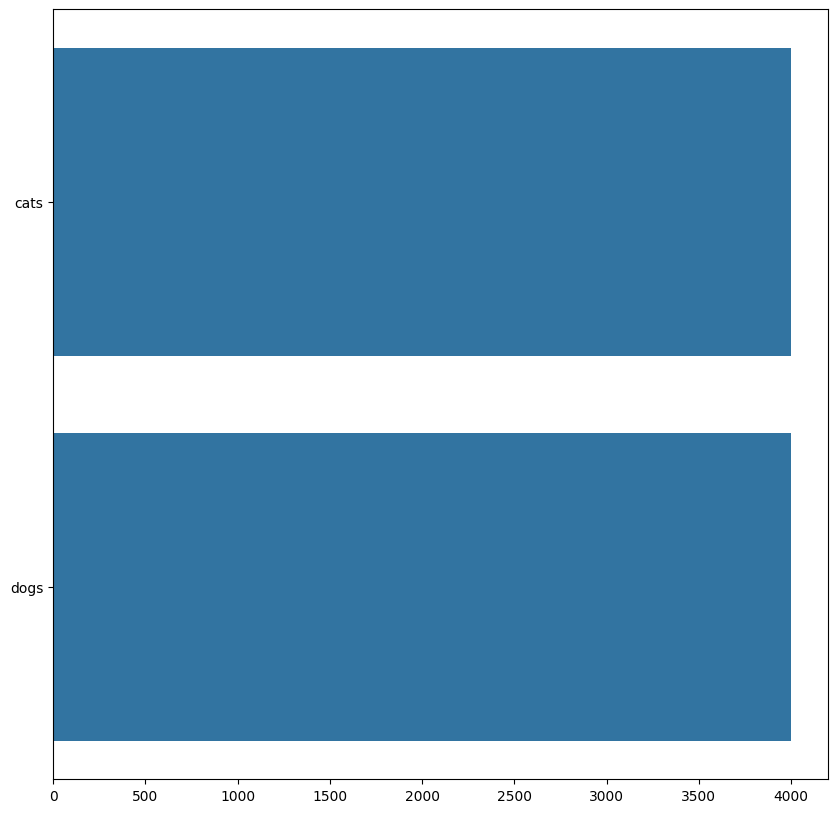

In [2]:
import feature_engineering as fe

train_dir, _, test_dir = fe.dataset_sub_division(path)

classes = fe.analisys_dataset_composition(train_dir)

In [3]:
import tensorflow as tf

# Parametri del dataset
img_size = (256, 256)
batch_size = 8

# Caricamento automatico delle immagini da cartelle (senza PyTorch)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Caricamento automatico delle immagini da cartelle (senza PyTorch)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Determina il numero di classi automaticamente
num_classes = len(train_ds.class_names)
print(f"Numero di classi: {num_classes}, Classi: {train_ds.class_names}")

# ✅ Convertire i target in one-hot encoding
def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds = train_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Numero di classi: 2, Classi: ['cats', 'dogs']


## Configuriamo l'esecuzione su GPU

In [4]:
import tensorflow as tf

print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

class CNN_model():
    
    def __init__(self, num_classes):
        super().__init__()
        self.model = keras.Sequential([
            # Block One
            layers.Conv2D(filters=32,
                        kernel_size=3, 
                        activation='relu', 
                        padding='same',
                        input_shape=[256, 256, 3]),
            layers.MaxPool2D(),

            # Block Two
            layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation='relu',
                        padding='same'),
            layers.MaxPool2D(),

            # Block Three
            layers.Conv2D(filters=128, 
                        kernel_size=3, 
                        activation='relu', 
                        padding='same'),
            layers.Conv2D(filters=128, 
                        kernel_size=3, 
                        activation='relu', 
                        padding='same'),
            layers.MaxPool2D(),

            # Head
            layers.Flatten(),
            layers.Dense(256, activation='relu'),  # Layer fully connected aggiuntivo per migliorare la capacità di apprendimento
            layers.Dropout(0.5),  # Dropout per evitare overfitting
            layers.Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid'),
        ])

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
            metrics=['categorical_accuracy' if num_classes > 2 else 'binary_accuracy'],
        )

In [6]:
# Creazione del modello
model = CNN_model(num_classes).model

# Addestramento della rete neurale
model.fit(
    train_ds,
    epochs=10,  # Modifica il numero di epoche se necessario
)

Epoch 1/10
1000/1000 [==============================] - 46s 42ms/step - loss: 0.9750 - binary_accuracy: 0.6009
Epoch 2/10
1000/1000 [==============================] - 42s 42ms/step - loss: 0.5779 - binary_accuracy: 0.6991
Epoch 3/10
1000/1000 [==============================] - 42s 42ms/step - loss: 0.4828 - binary_accuracy: 0.7691
Epoch 4/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.3748 - binary_accuracy: 0.8352
Epoch 5/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.2618 - binary_accuracy: 0.8919
Epoch 6/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1921 - binary_accuracy: 0.9242
Epoch 7/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1449 - binary_accuracy: 0.9449
Epoch 8/10
1000/1000 [==============================] - 48s 48ms/step - loss: 0.1201 - binary_accuracy: 0.9570
Epoch 9/10
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0859 - binary_accuracy: 0.9711
E

In [7]:
test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

250/250 [==============================] - 3s 13ms/step - loss: 1.0218 - binary_accuracy: 0.7442
Test Loss: 1.0218493938446045
Test Accuracy: 0.7442499995231628
